### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Run all cells** (in the menubar, select Runtime$\rightarrow$Run All).
3. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
4. **Add the downloaded notebook (.ipynb file) to the submission zip**.

Make sure you fill in any place that says `YOUR CODE HERE` or "**WRITE YOUR ANSWER IN THIS CELL**", and that no tests fail.  
Write the IDs of all group members in the cell below. Leave any surplus IDs as `""`.

ID1 = ""  
ID2 = ""

---

## A Gentle Exploration of Word Vectors

### Why Word Vectors?

Say you want to build a model that takes a sentence as an input and outputs, for each word in that sentence, if it is a noun, verb, adjective, or something else. In the literature, this is known as [part-of-speech (POS) tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging). One of the most important design choices in a model is how to represent the input. In our case, the input could be seen as a list of words.

Given current trends, say we decide to implement our model using neural networks (if you have yet to take Introduction to Machine Learning, assume for now that neural networks are essentially a computational model that takes vectors as input). Therefore, a natural way of representing our input in such a model is with vectors, where each word in the sentence is represented by a vector.

But how do we create 'good' word vectors? And furthermore, what makes one set of word vectors better than another?

In our POS example, we want that the information encoded in the word vectors will help our model to correctly predict the part of speech tags for a given input sentence. And if using a set of word vectors $S_1$ in our model leads to better results than using word vectors $S_2$, we could say that $S_1$ are better word vectors than $S_2$. But what if another researcher reports that in his _translation_ model, using $S_2$ leads to better results than using $S_1$?

As you probably expect, good word vectors are also expected to be generalizable i.e. perform well overall in a variety of tasks, such as the aforementioned POS tagging and translation. In NLP literature, these tasks are commonly referred to as "[downstream tasks](https://stackoverflow.com/a/54518001/2133678)", highlighting the distinction between the actual process of _creating_ word vectors, and the word vectors' ability to be _utilized_ in various other tasks.

In this notebook, we'll explore two methods aimed to create 'good' word vectors: _co-occurrence matrices_ and _word2vec_.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension".

## Preliminary Imports and Settings
Before proceeding to the next parts, please run the cell below.  
**Do not change its contents.**

In [4]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5

import itertools
import pprint
import random

import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from nltk.corpus import reuters
from sklearn.decomposition import TruncatedSVD

# matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 5]

# downloads the Reuters corpus
nltk.download('reuters')

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\AvivYaniv\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Part 1: Count-Based Word Vectors

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e., words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | \<START\> | all | that | glitters | is   | not  | gold  | well | ends | \<END\> |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| \<START\>    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| \<END\>      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add \<START\> and \<END\> tokens to represent the beginning and end of sentences, paragraphs or documents. In our case we imagine \<START\> and \<END\> tokens encapsulating each document, e.g., "\<START\> All that glitters is not gold \<END\>", and include these tokens in our co-occurrence counts. You can see how we addressed this issue at the bottom of the initial 'imports' cell.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](https://i.imgur.com/u0qTrf1.png)

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you need quicker refresher just on SVD, check out this [comforting short video](https://www.youtube.com/watch?v=mBcLRGuAFUk). In practice, it is challenging to apply full SVD to large [corpora](https://www.merriam-webster.com/dictionary/corpora) because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as _[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)_ — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the [Reuters corpus](https://www.nltk.org/book/ch02.html#reuters-corpus). If you haven't run the import cell at the top of this page, please run it now. The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds \<START\> and \<START\> tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [7]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name.
        Return:
            list of lists, with words from each of the processed files.
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look on how these documents are like….

In [8]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:2], compact=True, width=120)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the', 'ministry', 'of',
  'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise', 'its', 'long', '-', 'term', 'energy',
  'supply', '/', 'demand', 'outlook', 'by', 'august', 'to', 'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese',
  'energy', 'demand', ',', 'ministry', 'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the',
  'projection', 'for', 'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows', 'the', 'emergence',
  'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following', 'the', 'rise', 'in', 'the', 'value', 'of',
  'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic', 'electric', 'power', 'demand', '.', 'miti', 'is', 'planning',
  'to', 'work', 'out', 'a', 'revised', 'energy', 'supply', '

### Question 1.1: Implement `distinct_words`

Write a method to work out the distinct words (word types) that occur in the corpus

In [30]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents.
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus.
    """
    corpus_words = []
    num_corpus_words = -1
    
    # -------------------------
    # YOUR CODE HERE
    # -------------------------
    
    all_words_in_corpus = []
    # For each document (in corpus), adding it's words 
    for document in corpus:
       all_words_in_corpus.extend([word for word in document])
    
    # Get unique words by converting to a set
    unique_words = set(all_words_in_corpus)
    # Convert set to list
    unique_word_list = list(unique_words) 
    # Sorting list of words
    corpus_words = sorted(unique_word_list)
    # Number of distinct words is the list length 
    num_corpus_words = len(corpus_words)
    # -------------------------
    
    return corpus_words, num_corpus_words 

    

In [31]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["<START> All that glitters isn't gold <END>".split(" "), "<START> All's well that ends well <END>".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["<START>", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "<END>"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Non Exhaustive Tests!")
print ("-" * 80)


--------------------------------------------------------------------------------
Passed All Non Exhaustive Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix`

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering $n$ words before and $n$ words after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [76]:
 def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents.
            window_size (int): size of context window.
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # -------------------------
    # YOUR CODE HERE
    
    # Initializing the 'co-occurence matrix of word counts' with zeros
    # as no words has been counted yet...
    M = np.zeros((num_words, num_words))
    
    # Initializing the 'word2Ind' with indexes, for each word in the corpus 
    for i in range(num_words):
        word2Ind[words[i]] = i

    # Going over the documents in corpus
    for document in corpus:
        document_length = len(document)
        # Going over the words in each document
        for current_word_index in range(document_length):
            
            # Obtaining center word
            center_word = document[current_word_index]
            center_word_index = word2Ind[center_word]
            
            # Calculating window margins
            left_boundry = max(current_word_index - window_size, 0)
            right_boundry = min(current_word_index + window_size, document_length - 1)

            # Going over all words in the window, besides center word, and updating counts
            for window_word_index in range(left_boundry, right_boundry+1):
                if current_word_index != window_word_index:
                    window_word = document[window_word_index]                    
                    M[center_word_index][word2Ind[window_word]] += 1                    

    # -------------------------

    return M, word2Ind

In [77]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["<START> All that glitters isn't gold <END>".split(" "), "<START> All's well that ends well <END>".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)

word2Ind_ans = {END_TOKEN: 0, START_TOKEN: 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Non Exhaustive Tests!")
print ("-" * 80)


--------------------------------------------------------------------------------
Passed All Non Exhaustive Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim`

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [80]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts.
            k (int): embedding size of each word after dimension reduction.
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S.
    """    
    n_iter = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # -------------------------
    # YOUR CODE HERE
    
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components = k, n_iter = n_iter)
    svd.fit(M)
    M_reduced = svd.transform(M)
    
    # -------------------------

    print("Done.")
    return M_reduced

In [81]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["<START> All that glitters isn't gold END".split(" "), "<START> All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings`

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [104]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings.
            word2Ind (dict): dictionary that maps word to indices for matrix M.
            words (list of strings): words whose embeddings we want to visualize.
    """

    # -------------------------
    # YOUR CODE HERE
    
    FACTOR = 0.001
    FONT_SIZE = 14

    words_index = [word2Ind[word] for word in words]

    x_coords, y_coords = \
        [M_reduced[wi][0] for wi in words_index], \
        [M_reduced[wi][1] for wi in words_index]

    for i, word in enumerate(words):
        x, y = x_coords[i], y_coords[i]
        plt.scatter(x, y, marker = 'x', color = 'red')
        plt.text(x + FACTOR, y + FACTOR, word, fontsize = FONT_SIZE)
    plt.show()
    
    # -------------------------

--------------------------------------------------------------------------------
Outputted Plot:


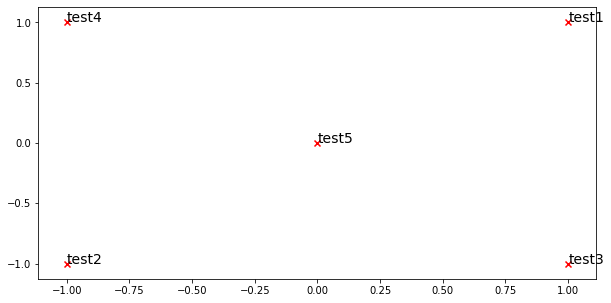

--------------------------------------------------------------------------------


In [105]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# If it hasn't the exact same proportions or if the markers look a bit off, that's OK.
# Generally, use your common sense here =)
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=blue>**Test Plot Solution**</font>
<br>
<img src="https://i.imgur.com/TvHeoRJ.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). 

**Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?

**Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


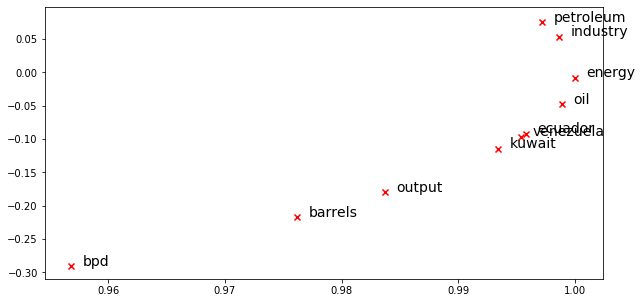

In [106]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

**WRITE YOUR ANSWER IN THIS CELL**
The countries {equador, venezuela} are close to each other, and it makes sense, because in our context they play similiar roles in terms of oil manufacturing.
We'd expact {bpd, barrels and output} which have almost the same semantic meaning and are exchangable to be closer.
Nonetheless, petroleum isn't clustered with oil, despite of being synonyms.

## Part 2: Prediction-Based Word Vectors

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Now, having implemented your own version of word2vec, consider challenging yourselves by reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Here, we shall explore the embeddings produced by word2vec. We will use embeddings that were already computed for us, not the embeddings we prepared ourselves in question 2 of this assignment.

Run the following cells to load the word2vec vectors into memory.  
**Note**: This might take several minutes.

In [97]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300.
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [98]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# If you are getting the following message, it is OK:
# "/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
#  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL"
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


### Reducing dimensionality of Word2Vec Word Embeddings

Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put 10,000 of the 3 million word2vec vectors into a matrix M.
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [99]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file.
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors.
            word2Ind: dictionary mapping each word to its row number in M.
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [100]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

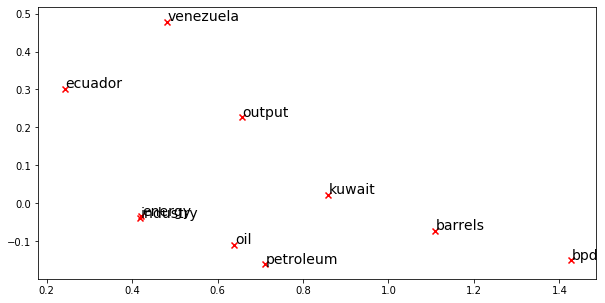

In [101]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

**WRITE YOUR ANSWER IN THIS CELL**
The points it this plot form two cureves versus in the last plot (1.5) which has been only one curve.
Moreover, this plot is decending whereas the las one is ascending.

The words {energy, industry} appear together in both algorithms; possible reason is that they are used in the same context in the oil-industry documents and also in other general documents.

Thw words {oil, petroleum} are closer to each other than in 1.5; the reason is that these words are considered a synonyms in a variety of documents. But the 'crude' documents from question 1 differentiates between these two words (they are less likely to appear in the same context).
 
On the other hand, the countries {venezuela, ecuador} appear far from each other in the chart. This is because the word2vec embeddings were not trained on an 'crude' corpus, and there are differences between the countries.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in an n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://i.imgur.com/D4a8vnr.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Polysemous Words
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from **both** meanings. For example, "leaves" has both "vanishes" and "[stalks](https://en.wiktionary.org/wiki/stalk#Noun)" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [114]:
# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("mole")

# ------------------

[('statewide', 0.5794690847396851),
 ('thestate', 0.5723356008529663),
 ('district', 0.54634690284729),
 ('State', 0.5446770191192627),
 ('county', 0.5432934761047363),
 ('Legislature', 0.5160354375839233),
 ('districts', 0.5100605487823486),
 ('federal', 0.503481924533844),
 ('commonwealth', 0.5022697448730469),
 ('stateís', 0.4989703893661499)]

**WRITE YOUR ANSWER IN THIS CELL**
We found the word 'mole' which both means 'freckle' or in the context of 'cancerous_mole' and also used to describe 'spies'.
For other words their polysemous words are less common or relativly less proximate in text, so we hadn't seen them in the top ten.


### Question 2.3: Synonyms & Antonyms

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to antonym w3="sad" than to synonym w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [124]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "friend"
w2 = "ally"
w3 = "enemy"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms \"{}\", \"{}\" have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms \"{}\", \"{}\" have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms "friend", "ally" have cosine distance: 0.566796064376831
Antonyms "friend", "enemy" have cosine distance: 0.7228574752807617


**WRITE YOUR ANSWER IN THIS CELL**
The cosine-distance between the antonyms {friend, enemy} is smaller than in the synonyms {friend, ally}; as the antonyms appear more proximate to each other in texts, however, the words {friend, ally} aren't often to appear together.

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : y", what is y?

In the cell below, we show you how to use word vectors to find y. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [125]:
# Run this cell to answer the analogy -- man : king :: woman : ?
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


### Question 2.4: Finding Analogies
Find an example of an analogy that holds (i.e. the intended word is ranked top according to these vectors (`wv_from_bin`). In your solution please state the full analogy in the form a:b :: x:y. If you believe the analogy is complicated explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works! Try learning some properties of the word vectors from your unsuccessful attempts.

In [133]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'his'], negative=['boy']))

# ------------------

[('her', 0.8093730211257935),
 ('Her', 0.6147782802581787),
 ('my', 0.6075835227966309),
 ('His', 0.5774028301239014),
 ('herself', 0.5670921802520752),
 ('she', 0.5415224432945251),
 ('him', 0.5350818037986755),
 ('he', 0.5118668675422668),
 ('hers', 0.5049200654029846),
 ('himself', 0.4891963601112366)]


**WRITE YOUR ANSWER IN THIS CELL**
boy : his :: girl : her

### Question 2.5: Incorrect Analogy
Find an example of an analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form a:b :: x:y, and state the (incorrect) value of b according to the word vectors.

In [134]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['flower', 'leaf'], negative=['tree']))

# ------------------

[('floral', 0.5532568693161011),
 ('marigold', 0.5291938185691833),
 ('tulip', 0.521312952041626),
 ('rooted_cuttings', 0.5189826488494873),
 ('variegation', 0.5136324763298035),
 ('Asiatic_lilies', 0.5132641792297363),
 ('gerberas', 0.5106234550476074),
 ('gerbera_daisies', 0.5101010203361511),
 ('Verbena_bonariensis', 0.5070016980171204),
 ('violet', 0.5058108568191528)]


**WRITE YOUR ANSWER IN THIS CELL**
tree : leaf :: flower : petal

The word 'petal' dosen't appear in the top 10

### Question 2.6: Bias in Word Vectors

Implicit Biases (regarding gender, race, sexual orientation etc.) in word vectors is an [interesting](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings) [and](https://arxiv.org/abs/1810.03611) [hot](https://arxiv.org/abs/1812.08769) [research](https://www.aclweb.org/anthology/S19-1010/) [topic](https://www.aclweb.org/anthology/N19-1064/).

To get a little glimpse, run the cell below to examine (a) which terms are most similar to "woman" and "doctor" and most dissimilar to "man", and (b) which terms are most similar to "man" and "doctor" and most dissimilar to "woman". What do you find in the top 10?

In [135]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
print('\033[1m Trying to solve "man:doctor :: woman:? \033[0m')
print('\033[1m "man" is to "doctor" what "woman" is for: \033[0m')
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'doctor'], negative=['man']))
print()
print('\033[1m Trying to solve "woman:doctor :: man:? \033[0m')
print('\033[1m "woman" is to "doctor" what "man" is for: \033[0m')
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'doctor'], negative=['woman']))

 Trying to solve "man:doctor :: woman:? 
 "man" is to "doctor" what "woman" is for: 
[('gynecologist', 0.7093892097473145),
 ('nurse', 0.647728681564331),
 ('doctors', 0.6471461057662964),
 ('physician', 0.64389967918396),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072014570236206),
 ('ob_gyn', 0.5986712574958801),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]

 Trying to solve "woman:doctor :: man:? 
 "woman" is to "doctor" what "man" is for: 
[('physician', 0.6463665962219238),
 ('doctors', 0.5858404040336609),
 ('surgeon', 0.5723941326141357),
 ('dentist', 0.552364706993103),
 ('cardiologist', 0.5413815975189209),
 ('neurologist', 0.5271126627922058),
 ('neurosurgeon', 0.5249835848808289),
 ('urologist', 0.5247740149497986),
 ('Doctor', 0.5240625143051147),
 ('internist', 0.5183224081993103)]


**WRITE YOUR ANSWER IN THIS CELL**
(a) The words {gynecologist, obstetrician} and escpecially {nurse, midwife, nurse_practitioner} expose some gender bias.

(b) The words {surgeon, dentist, cardiologist, neurosurgeon, urologist, internist} expose some gender bias.

### Question 2.7: Thinking About Bias

What might be the cause of these perceived biases in the word vectors?

**WRITE YOUR ANSWER IN THIS CELL**
The data itself is biased:
Althogh there are many talented women, and especially doctors; it is more common in articles and in the general media for women to appear in proximity with gender biased occupations, and it is reflected on the data. 